# Основная информация

# Predict TripAdvisor Rating

## Цель проекта 

**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### Предоставленное описание датасета

* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана



## Этапы выполнения проекта

1. Загрузка и первичный отсмотр данных.
2. Проверка и анализ имеющихся признаков.
3. Создание и отбор признаков, выбор формы модели.
4. Коррелляционный анализ, наличие выбросов и аномалий.
5. Создание модели, работающей на алгоритме машинного обучения, для предсказания целевого признака.
6. Оценка качества работы модели и другие итоги работы.


# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import re
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/ta-keywords/words_keys.csv
/kaggle/input/ta-ranks/ranks.csv
/kaggle/input/world-cities-datasets/worldcities.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
ranks = pd.read_csv("/kaggle/input/ta-ranks/ranks.csv").drop(['Unnamed: 0','claimed'], axis=1).drop_duplicates(subset=['url'])
wordcounts = pd.read_csv("/kaggle/input/ta-keywords/words_keys.csv", sep=';').drop(['Unnamed: 0'],axis=1)
cities = pd.read_csv('/kaggle/input/world-cities-datasets/worldcities.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

### Посмотрим распределение признака

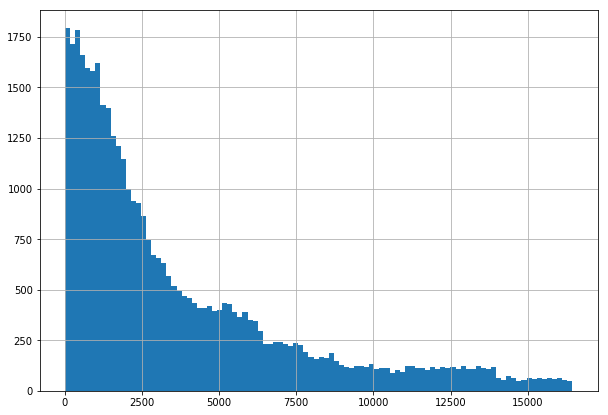

In [10]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

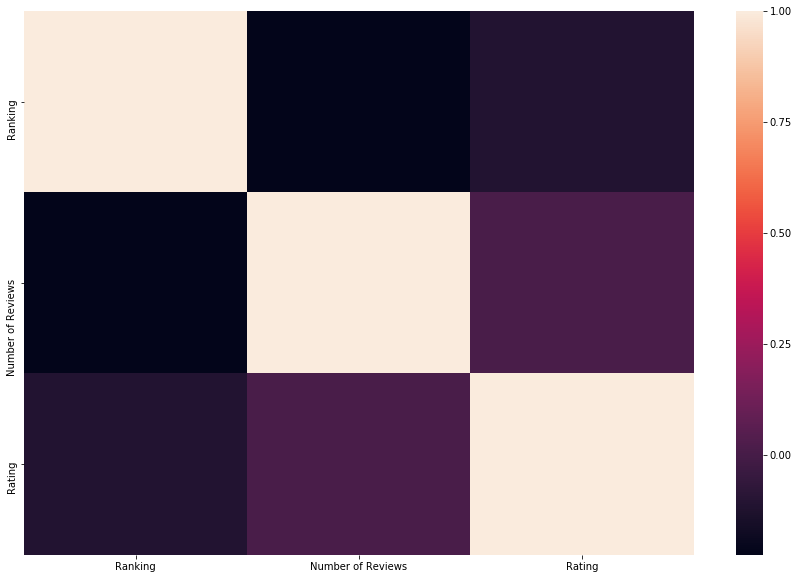

In [11]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [12]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')


df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [13]:
#Additional data sets
ranks = pd.read_csv("/kaggle/input/ta-ranks/ranks.csv").drop(['Unnamed: 0','claimed'], axis=1).drop_duplicates(subset=['url'])
wordcounts = pd.read_csv("/kaggle/input/ta-keywords/words_keys.csv", sep=';').drop(['Unnamed: 0'],axis=1)
cities = pd.read_csv('/kaggle/input/world-cities-datasets/worldcities.csv')

In [14]:
# Конвертация уровня стоимости
def conv_price(x):
    d = {
        '$$ - $$$':2,
        '$': 1,
        '$$$$':3
    }
    if x in d.keys():
        return d[x]
    elif pd.isnull(x):
        return float('NaN')
    else:
        return float('NaN')
# Конвертация Cuisine Style
def conv_cuisine(x):
    lx=re.compile('\[.*\]')
    if type(x)==str and lx.fullmatch(x):
        lst=eval(x)
        return lst
    #elif pd.isnull(x):
    else:
        return ['NaN']

In [15]:
def gen_values_set(data, colname):
    vals=set()
    lx=re.compile('\[.*\]')
    for v in data[colname]:
        if type(v)==str and lx.fullmatch(v):
            lst=eval(v)
            for x in lst:
                vals.add(x)
        elif type(v)==list:
            lst=v
            for x in lst:
                vals.add(x)
        else:
            vals.add(v)
    return vals
# Функция создания Dummies (поддерживает списки)
def gen_valcols(colname, df):
    vals=gen_values_set(df, colname)

    def find_item(item):
        if type(item)==str:
            if v==item:
                return 1
            else:
                return 0
        elif type(item)==list:
            if v in item:
                return 1
            else:
                return 0
            
    for v in vals:
        df[colname+v]=df[colname].apply(lambda x: find_item(x))

In [16]:
lrx=re.compile('\[\[.*\]\]')
def extr_rev(row):
    #print(row)
    x=row['Reviews']
    lst=[[],[]]
    if type(x)== str and lrx.fullmatch(x):
        nan=''
        lst=eval(x)
#CORR
#    row['rev_count'] =  len(lst[0])
    row['rev1'] = lst[0][0] if len(lst[0])>0 else ''
    row['rev2'] = lst[0][1] if len(lst[0])>1 else ''
    
    row['date1'] = pd.to_datetime(lst[1][0] if len(lst[1])>0 else '', format='%m/%d/%Y', errors='coerce')
    row['date2'] = pd.to_datetime(lst[1][1] if len(lst[1])>1 else '')
    
    row['date1']= pd.to_datetime(row['date1'])
    row['date2']=pd.to_datetime(row['date2'])
    
    return row

In [17]:

def get_date_delta(row, date_min, date_max):
    date1=row['date1']
    date2=row['date2']
    delta = date_max-date_min
    if not pd.isnull(date1) and not pd.isnull(date2):
        #print(date2, date1, date2-date1)
        delta = date1 - date2 if date2<date1 else date2-date1
    elif not pd.isnull(date1):
        delta = date1 - date_min
    return delta.total_seconds()

def get_last_date_delta(row, date_min, date_max):
    date1=row['date1']
    date2=row['date2']
    last_date=date_min
    if not pd.isnull(date1):
        last_date=date1
    if (not pd.isnull(date2)) and date2 > date1:
        last_date=date2
#    return (datetime.now()-last_date).total_seconds()
    return (date_max-last_date).total_seconds()

def get_first_date_delta(row, date_min, date_max):
    date1=row['date1']
    date2=row['date2']
    first_date=date_min
    if not pd.isnull(date1):
        first_date=date1
    if (not pd.isnull(date2)) and date2 < date1:
        first_date=date2
    return (first_date - date_min).total_seconds()

In [18]:
allwords=pd.Series()
def collectwords(x):
    print(type(x))
    global allwords
    #x=map(lambda s: s.lower(), x)
    #s=pd.Series(x)
    allwords=allwords.append(x.str.lower())
    
def get_dummies_words(df,colname, words, init=True):
    words_re=re.compile('\w+')
    def find_item(row):
        item=row[colname]
        if type(item)==str:
            lst=list(words_re.findall(item.lower()))
            count = 0
#            for v in words:
#                if v in lst:
#                #if v in item.lower():
#                    
#                    row[prefix+v]=row[prefix+v]+1
#                    count = count + 1
            for v in lst:
                if v in words:
                    row[prefix+v]=row[prefix+v]+1
                    count = count + 1
            row[prefix + 'COUNT']=row[prefix + 'COUNT']+len(lst)
            row[prefix + 'NOWORDS']= row[prefix + 'NOWORDS'] + (1 if count == 0 else 0)
        return row
        
    prefix='word_'
    if init:
        for v in words:
            df[prefix+v]=0
            df[prefix + 'COUNT']=0
            df[prefix + 'NOWORDS']=0
            
    df=df.apply(find_item, axis=1)
    return df

In [19]:
def is_closed(x):
    if pd.isna(x['rank1']) and pd.isna(x['rank2']) and pd.isna(x['rank_main']):
        return 1
    else:
        return 0

def top_rank(x):
    top_rank = x['Ranking']
    if not(pd.isna(x['rank1'])) and top_rank < x['rank1']:
        top_rank = x['rank1']
    if not(pd.isna(x['rank2'])) and top_rank < x['rank2']:
        top_rank = x['rank2']
    if not(pd.isna(x['rank_main'])) and top_rank < x['rank_main']:
        top_rank = x['rank_main']
    return float(top_rank)

def get_rank_norm(x, field, ranks_by_city):
    maxr = ranks_by_city.loc[x['City']][( field, 'max')] / ranks_by_city.loc[x['City']][( 'population', 'max')]
    minr = ranks_by_city.loc[x['City']][( field, 'min')] / ranks_by_city.loc[x['City']][( 'population', 'max')]
    res=x[field]/ ranks_by_city.loc[x['City']][( 'population', 'max')]
    return (res - minr) / (maxr - minr)

In [20]:
def round_rating(x):
    return (round(x*2.0)/2)

def norm(x, fieldname):
    return (x[fieldname]-x[fieldname].min())/(x[fieldname].max()-x[fieldname].min())

In [21]:
def is_local_cuisine(row):
    local_cuisine_by_country = {
        'United Kingdom':['British','Scottish'],
        'Spain': ['Spanish'],
        'France': ['French','Central European'], 
        'Italy': ['Italian','Central European'],
        'Germany': ['Dutch','German','Central European'],
        'Portugal': ['Portuguese'],
        'Czechia': ['Czech','Eastern European'],
        'Poland':['Polish','Eastern European'],
        'Austria': ['Austrian','Central European'],
        'Netherlands':['Scandinavian'],
        'Belgium': ['Belgian','Eastern European'],
        'Switzerland':['Swiss','Central European'],
        'Sweden':['Scandinavian'],
        'Hungary':['Hungarian','Eastern European'],
        'Ireland':['Irish'],
        'Denmark':['Scandinavian'],
        'Greece':['Greece'],
        'Norway':['Scandinavian'],
        'Finland':['Scandinavian'],
        'Slovakia':['Eastern European'],
        'Luxembourg':['Eastern European'],
        'Slovenia':['Slovenian','Eastern European']
    }
    loc_cus = local_cuisine_by_country[row['country']]
    for l in loc_cus:
        if l in row['Cuisine_'] and l != '':
            return 1
    else:
        return 0
    return 0

def is_pop_cuisine(row):
    pop_cuisine = ['Cafe','Grill','International','Mediterranean','Fast Food','Pizza','Pub','Sushi']
    
    for l in pop_cuisine:
        if l in row['Cuisine_'] and l != '':
            return 1
    else:
        return 0
    return 0

def is_veget_cuisine(row):
    veget_cuisine = ['Vegetarian Friendly', 'Healthy', 'Vegan Options', 'Gluten Free Options']
    
    for l in veget_cuisine:
        if l in row['Cuisine_'] and l != '':
            return 1
    else:
        return 0
    return 0

In [22]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    
    #df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    df_output['rest_id']=df_output['Restaurant_id'].apply(lambda x: x[3:])
    df_output['id_ta']=df_output['ID_TA'].apply(lambda x:int(x[1:]))
    rurl_id = re.compile('Review-g(\d+)-')
    df_output['url_']=df_output['URL_TA'].apply(lambda s: rurl_id.findall(s)[0])
    
    df_output['Number_of_Reviews_isNAN'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    
    # ################### 2. NAN ############################################################## 
    # Далее заполняем пропуски, вы можете попробовать заполнением средним или средним по городу и тд...
    df_output['Number of Reviews'].fillna(0, inplace=True)
    # тут ваш код по обработке NAN
    # ....
    df_output['nreviews_norm']=(df_output['Number of Reviews']-df_output['Number of Reviews'].min())/(df_output['Number of Reviews'].max()-df_output['Number of Reviews'].min())
    
#CORR
#    df_output.drop(['Number of Reviews'], axis=1, inplace=True)
    
    # ################### 3. Encoding ############################################################## 
    # для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
    #Перенесена ниже
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    # тут ваш код не Encoding фитчей
    
    # Price Range
    df_output['Price_']=df_output['Price Range'].apply(conv_price)
    price_mean = df_output['Price_'].dropna().mean()
#CORR: Уровень цен 
    price_top = df_output['Price_'].dropna().nlargest(1).iloc[0]
    df_output['Price_'].fillna(price_top, inplace=True)

    global cities, ranks, wordcounts    
    
    # City -> Country, capital, population
    df_output['City'] = df_output['City'].apply(lambda x: 'Porto' if x =='Oporto' else x)
#CORR: Убираем города    
    gen_valcols('City', df_output)

    cities = cities.drop(cities[cities.country == 'United States'].index, axis=0)
    cities = cities.drop(cities[cities.country == 'Canada'].index, axis=0)
    cities = cities.drop(cities[cities.country == 'Venezuela'].index, axis=0)
    df_output=df_output.merge(cities[['city_ascii','capital','country','population', 'lat', 'lng']], how='left', left_on='City', right_on='city_ascii')
    
    df_output['pop_n']=norm(df_output, 'population')
# CORR: Убираем координаты
    df_output['lat_n']=norm(df_output, 'lat')
    df_output['lng_n']=norm(df_output, 'lng')
#    df_output.drop(['population','lat','lng'], axis=1, inplace=True)
    df_output.drop(['lat','lng'], axis=1, inplace=True)
    
    # Cuisine Style
    df_output['Cuisine_']=df_output['Cuisine Style'].apply(conv_cuisine)
    df_output['Cuisine_count'] = df_output['Cuisine_'].apply(lambda x: len(x))
    df_output['Cuisine_count_n']=norm(df_output,'Cuisine_count')
    df_output.drop(['Cuisine_count'], axis=1, inplace=True)
    
    df_output['local_cuisine']=df_output.apply(is_local_cuisine, axis=1)
    df_output['pop_cuisine']=df_output.apply(is_pop_cuisine, axis=1)
    df_output['veget_cuisine']=df_output.apply(is_veget_cuisine, axis=1)
    #gen_valcols('Cuisine_', df_output)
    
    # ################### 4. Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
#CORR: Страна?
#    df_output=pd.get_dummies(df_output, columns=['capital', 'country'], dummy_na=True)
    df_output=pd.get_dummies(df_output, columns=['country'], dummy_na=True)
    
    
    
    #Rankings adds
    df1 = df_output.merge(ranks, left_on='URL_TA', right_on='url', how='left')
    df_output = df1
    df_output['closed']=df_output.apply(is_closed, axis=1)
    df_output['top_rank']=df_output.apply(top_rank, axis=1)
    df_output.drop(['rank1', 'rank2', 'url', 'rank_main'], axis=1, inplace=True)
    
    ranks_by_city = df_output.groupby('City')[['Ranking', 'top_rank', 'Number of Reviews', 'population']].agg(['max', 'min'])
    df_output['rank_norm'] = df_output[['Ranking', 'City']].apply(get_rank_norm, axis=1, field='Ranking', ranks_by_city=ranks_by_city)

    df_output['rank_top_norm'] = df_output[['top_rank', 'City']].apply(get_rank_norm, axis=1, field='top_rank', ranks_by_city=ranks_by_city)
    
#    df_output['nreviews_norm'] = df_output[['Number of Reviews', 'City']].apply(get_rank_norm, axis=1, field='Number of Reviews', ranks_by_city=ranks_by_city)
    
    df_output.drop(['Ranking', 'top_rank', 'Number of Reviews', 'population'], axis=1, inplace=True)
        
    
    #Reviews
    # - Base
    df_output=df_output.apply(extr_rev, axis=1)
    
    # - Dates
    date_min = min([df_output.date1.min(),df_output.date2.min()])
    date_max = max([df_output.date1.max(),df_output.date2.max()])
    df_output['date_delta_sec']=df_output[['date1','date2']].apply(get_date_delta, axis=1, date_min=date_min, date_max=date_max)
    df_output['last_date_delta']=df_output[['date1','date2']].apply(get_last_date_delta, axis=1, date_min=date_min, date_max=date_max)
    df_output['first_date_delta']=df_output[['date1','date2']].apply(get_first_date_delta, axis=1, date_min=date_min, date_max=date_max)

#CORR Даты    
    df_output['date_delta_n']=norm(df_output,'date_delta_sec')
    df_output['last_date_delta_n']=norm(df_output,'last_date_delta')
    df_output['first_date_delta_n']=norm(df_output,'first_date_delta')

    df_output['date_n_mult']=df_output['date_delta_n'] * df_output['first_date_delta_n']
    df_output.drop(['date_delta_n','last_date_delta_n','first_date_delta_n'],axis=1, inplace=True)
    
    df_output.drop(['date_delta_sec','last_date_delta','first_date_delta'],axis=1, inplace=True)

    # - Words in Review
    df_output=get_dummies_words(df_output, 'rev1',wordcounts.word)
    df_output=get_dummies_words(df_output, 'rev2',wordcounts.word, init=False)
    
    df_output['word_COUNT_n'] = norm(df_output, 'word_COUNT')
    df_output.drop(['word_COUNT'], axis=1, inplace=True)
    
    #df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    # ################### 5. Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
    object_columns = [s for s in df_output.columns if df_output[s].dtypes in ['object','<m8[ns]','<M8[ns]']]
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

>По хорошему, можно было бы перевести эту большую функцию в класс и разбить на подфункции (согласно ООП). 

#### Запускаем и проверяем что получилось

In [23]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,sample,Rating,id_ta,Number_of_Reviews_isNAN,nreviews_norm,Price_,CityBerlin,CityParis,CityPrague,CityHamburg,...,word_incredible,word_overpriced,word_enjoyable,word_reasonable,word_slow,word_convenient,word_recommended,word_relaxing,word_modern,word_COUNT_n
8471,0,0.0,12322445,0,0.000207,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.40
34677,1,3.5,11717359,0,0.001346,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.35
11189,1,4.0,4006807,0,0.001760,3.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.00
49492,1,3.5,3792616,0,0.001139,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.30
2379,0,0.0,8733614,1,0.000000,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.20
610,0,0.0,1643207,0,0.075259,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.55
32890,1,4.5,5616788,0,0.035300,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.40
30261,1,4.5,12956730,0,0.000932,3.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.35
4833,0,0.0,3649375,0,0.006004,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.50
33900,1,4.0,796361,0,0.033747,2.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.20


In [24]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Columns: 134 entries, sample to word_COUNT_n
dtypes: float64(11), int64(123)
memory usage: 52.7 MB


In [25]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [26]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [27]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 133), (40000, 133), (40000, 132), (32000, 132), (8000, 132))

# Model 
Сам ML

In [28]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [29]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [30]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [31]:
y_pred=list(map(round_rating,y_pred))

In [32]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1596875


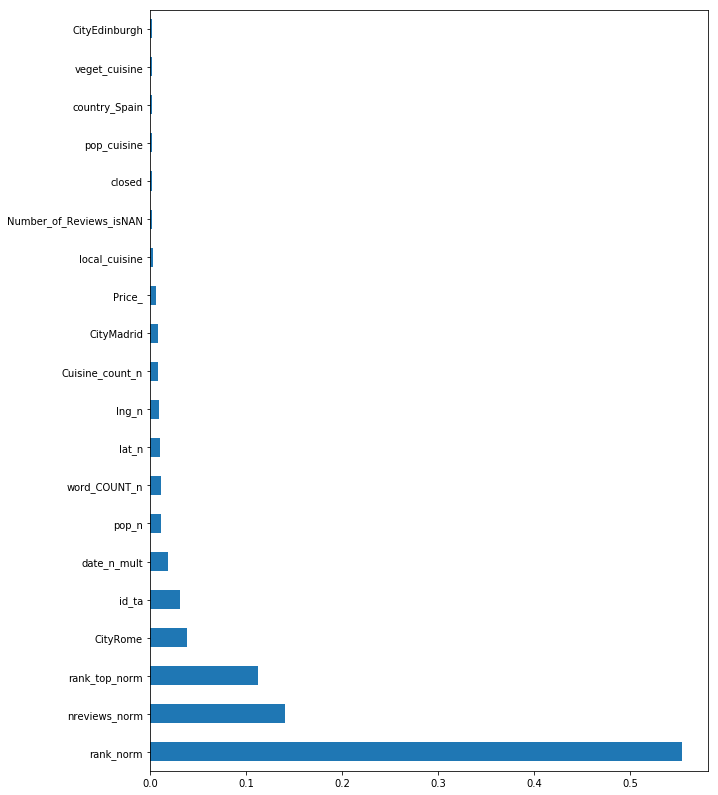

In [33]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,14)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [34]:
test_data.sample(10)

,Rating,id_ta,Number_of_Reviews_isNAN,nreviews_norm,Price_,CityBerlin,CityParis,CityPrague,CityHamburg,CityOslo,...,word_incredible,word_overpriced,word_enjoyable,word_reasonable,word_slow,word_convenient,word_recommended,word_relaxing,word_modern,word_COUNT_n
7311,0.0,7621764,0,0.000518,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.55
8324,0.0,4601411,0,0.025155,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.20
5277,0.0,10487845,0,0.004658,1.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.25
8424,0.0,1510791,0,0.019358,2.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.20
1020,0.0,2000080,0,0.006004,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.35
3983,0.0,11734261,0,0.001035,2.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
3427,0.0,5798768,0,0.000414,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.00
8712,0.0,7315722,0,0.043996,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.30
9019,0.0,1890886,0,0.011594,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.55
3076,0.0,1044600,0,0.000518,3.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.45


In [35]:
test_data = test_data.drop(['Rating'], axis=1)

In [36]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [37]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [38]:
predict_submission=list(map(round_rating,predict_submission))

In [39]:
predict_submission

[3.0,
 4.0,
 4.0,
 4.5,
 4.5,
 4.5,
 1.5,
 3.0,
 4.0,
 4.5,
 4.0,
 3.5,
 4.0,
 4.0,
 3.5,
 3.0,
 3.5,
 4.0,
 2.5,
 4.0,
 4.0,
 4.5,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.5,
 3.5,
 3.5,
 4.0,
 5.0,
 3.5,
 3.5,
 5.0,
 4.0,
 4.5,
 4.5,
 4.0,
 5.0,
 4.5,
 3.0,
 4.0,
 3.5,
 4.0,
 3.0,
 4.0,
 3.5,
 5.0,
 3.5,
 3.5,
 4.5,
 4.0,
 5.0,
 4.5,
 3.5,
 3.5,
 4.0,
 4.0,
 4.0,
 4.5,
 4.5,
 4.5,
 4.0,
 4.5,
 3.5,
 4.5,
 4.5,
 4.0,
 4.5,
 2.5,
 4.5,
 4.0,
 4.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 4.5,
 5.0,
 4.5,
 3.0,
 4.5,
 3.0,
 4.0,
 4.5,
 4.5,
 4.0,
 3.5,
 4.5,
 4.0,
 4.5,
 3.0,
 3.5,
 4.0,
 3.5,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.5,
 4.5,
 4.5,
 4.0,
 4.0,
 4.0,
 3.5,
 4.5,
 4.0,
 4.0,
 5.0,
 3.5,
 4.5,
 3.5,
 4.0,
 3.5,
 4.5,
 4.0,
 4.5,
 4.0,
 4.0,
 4.0,
 3.0,
 2.5,
 4.5,
 4.0,
 2.5,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 3.5,
 4.5,
 5.0,
 4.0,
 5.0,
 4.5,
 3.5,
 3.5,
 4.5,
 3.5,
 4.0,
 4.0,
 3.5,
 4.5,
 4.0,
 4.5,
 1.0,
 5.0,
 4.5,
 4.5,
 3.5,
 4.0,
 4.0,
 4.0,
 3.5,
 4.5,
 4.0,
 3.5,
 4.0,
 3.5

In [40]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,3.0
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
